# 3. HPC PDE Solver - The linear algebra part

## Requirements

In order to fully understand this notebook, please be sure to have already taken a look at the notebooks:
* **0_hpc_mpi_tutorial**
* **1_hcp_pde_data**
* **2_hpc_pde_diffusion**

**As before it is adviced to run this Jupyter notebook with 4 processes**. 


## The linear algebra part of the mini-app

Remember from before that we have a system of non-linear equations (one per grid point) and each equation is of the form: 

$f_{i,j}^{k} := -(4+\alpha)S_{i,j}^{k}+S_{i-1,j}^{k}+S_{i+1,j}^{k}+S_{i,j-1}^{k}+S_{i,j+1}^{k}+\beta S_{i,j}^{k}(1-S_{i,j}^{k}) +\alpha S_{i,j}^{k-1}$

Now, we have to solve this system to get the actual values of the matrix at the current time step. In order to do so, we use the **Newton's Method**: 

$y^{l+1} = y^{l} - [J_{f}(y^{l})]^{-1} f(y^{l})$

Where: 
* $y^{l+1}$ is the solution at next time step:`x_new`.
* $y^{l}$ is the solution at previous time step:`x_old`.
* $[J_{f}(y^{l})]^{-1}$ is the inversed of the Jacobian of `x_old`.
* $f(y^{l})$ is the resulting `S` from inputting `x_old` in the diffusion function.

Because the inverse of the Jacobian is not readily available and is very costly to compute, we can rewrite the previous equation as: 

$$y^{l+1} - y^{l} = -[J_{f}(y^{l})]^{-1} f(y^{l}) \\
-[J_{f}(y^{l})](y^{l+1} - y^{l}) =  f(y^{l}) \\ 
[J_{f}(y^{l})](-y^{l+1} + y^{l}) =  f(y^{l}) \\
[J_{f}(y^{l})](y^{l} - y^{l+1}) =  f(y^{l}) \\
[J_{f}(y^{l})] \delta y^{l+1} =  f(y^{l})$$

The last form of this equation: $[J_{f}(y^{l})] \delta y^{l+1} =  f(y^{l})$ is of the form $Ax = b$. If we solve it for $x$ that is to say $\delta y^{l+1}$, we can then get the new solution. Solving this $Ax = b$ equation can be achieved using a **matrix-free Conjugate Gradient method**. Indeed, with this method, we avoid calculating and storing directly the Jacobian. Instead, the Jacobian vector product is formed. This latter is a vector and manipulating and calculating it is easier than working with a large matrix which would represent the Jacobian on its own.

After getting $\delta y^{l+1}$, we can get the solution $y^{l+1}$ by doing $y^{l+1} = y^{l} - \delta y^{l+1}$.

Thus, to summarize, at each time step, we will do one to several **Newton's iterations** to solve the system of non-linear equations. In each of these Newton's iterations, we will do one to several **Conjugate Gradient iterations** in order to get $\delta y^{l+1}$ and finish the current Newton's iteration.

We will come to the Newton's method in the last notebook which will be the full app. For now, we want to implemement the linear algebra part of our mini-app. This linear algebra part will be constituted of **3 functions**: 
* The norm function. 
* The dot function.
* The matrix-free Conjugate Gradient solver function. 

If you have already used Numpy in the past, you may think that implementing the norm and the dot functions is useless as they are already made for us in the package. However, you will see why we have to implement our own. Indeed, there is a slight difference to take into consideration, **we are using multiple processes**.

Initializing Ipyparallel and MPI:

In [1]:
import ipyparallel as ipp
rc = ipp.Client()
print("There are " + str(len(rc)) + " processes running in parallel")
print("IDs of the processes running in parallel", rc.ids)

There are 4 processes running in parallel
IDs of the processes running in parallel [0, 1, 2, 3]


In [2]:
%%px

from mpi4py import MPI as mpi
import numpy as np
import time
import math
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

print("Hello from process " + str(rank))

[stdout:0] Hello from process 0
[stdout:1] Hello from process 1
[stdout:2] Hello from process 2
[stdout:3] Hello from process 3


### Norm function - The idea 

Let's first think about the norm function. This one will be used to compute the residual at each Newton's iteration. If the residual is below a certain treshold, the process breaks out of the loop, meaning that the method has converged:

```python
for it in range (0, max_newton_iters):
    residual = norm(b)

    if residual < tolerance:
        converged = True
        break
```
**But the domain being different in each process, what if one breaks out of the loop while the others are still in?** It would lead to a deadlock or the program would crash. So **we have to kind of broadcast the same norm to all the processes**. This is the slight difference of our norm and dot functions. 

### Norm function - The code

Let's code it, we will use another MPI function `.Allreduce()` and we will do the following:
* In each process, we calculate the **intermediate result of its norm just before doing the square root**.
* Using the `.Allreduce()` function, all these intermediate results will be concatenated (**summed up**) to one result which will then be redistributed among each process. Thus, each process will have the same global result. 
* Finally each process will apply the square root to this global result and will return it. 

Thus, the residual will be the same among all processes, no one can leave before the others. 

In [3]:
%%px

# this function compute the norm and broadcast it to all the other processes so that each process has the same norm
def norm(b): 
    
    # Numpy array initialized
    result = np.zeros((1), dtype=np.float64) # intermediate result per process
    global_result = np.zeros((1), dtype=np.float64) # global (concatenated) result

    # sum of the elements of b to the power of 2
    # b**2 is the fastest way to put b to the power of 2 with Numpy
    result[0] += np.sum(b**2)
    
    print('Intermediate result:',result[0])
    
    # sum up the intermediate result of each process and broadcast it to the global_result variable of each of them
    # .Allreduce([result_of_each_proc_to_sum, type], [variable_holding_summed_results, type], operation_to_concatenate_result)
    MPI.COMM_WORLD.Allreduce([result, MPI.DOUBLE], [global_result, MPI.DOUBLE], op=MPI.SUM)
    
    print('Global result:',global_result[0])
    
    # the final global sum is squared and returned, each process will have the same norm
    return math.sqrt(global_result)

To test it, let's create a random matrix of integers for each process and see how it goes: 

In [4]:
%%px

b = np.random.randint(5, size=(2, 2))
print("Random matrix for domain", rank, ":\n", b)
print("Result of norm(b) for domain", rank, ":", norm(b))
print("")

[stdout:0] 
Random matrix for domain 0 :
 [[0 0]
 [0 3]]
Intermediate result: 9.0
Global result: 72.0
Result of norm(b) for domain 0 : 8.48528137423857

[stdout:1] 
Random matrix for domain 1 :
 [[4 0]
 [4 3]]
Intermediate result: 41.0
Global result: 72.0
Result of norm(b) for domain 1 : 8.48528137423857

[stdout:2] 
Random matrix for domain 2 :
 [[1 1]
 [3 1]]
Intermediate result: 12.0
Global result: 72.0
Result of norm(b) for domain 2 : 8.48528137423857

[stdout:3] 
Random matrix for domain 3 :
 [[0 1]
 [0 3]]
Intermediate result: 10.0
Global result: 72.0
Result of norm(b) for domain 3 : 8.48528137423857



**It works !**

### Dot funtion - The idea

The principle is exactly the same for the dot function, this one will be used to calculate the residual of the conjugate gradient method, thus no process must break out before the others if its residual is below the threshold.
```python
for iteration in range(0, maxiters): # maxiters for conjugate gradient
    rnew = dot(r.flatten(), r.flatten())

    if math.sqrt(rnew) < tol:
        success = True
        break
```

### Dot function - The code

The principle is the same for the norm function, the only difference here is that we are doing the dot product of 2 vectors.

In [5]:
%%px

# compute the dot product of two vectors and broadcast it to all the other processes so that each process has the same dot
def dot(x, y):

    result = np.zeros((1), dtype=np.float64)
    global_result = np.zeros((1), dtype=np.float64)
   
    result[0] = np.dot(x, y)
    
    print('Intermediate result:',result[0])
    
    MPI.COMM_WORLD.Allreduce([result, MPI.DOUBLE], [global_result, MPI.DOUBLE], op=MPI.SUM)
    
    print('Global result:',global_result[0])

    return global_result

Let's test it:

In [6]:
%%px

a = np.random.randint(5, size=(5))
b = np.random.randint(5, size=(5))
print("Random vectors for domain", rank, ":\n", a, b)
print("Result of dot(a, b) for domain", rank, ":", dot(a, b)[0])
print("")

[stdout:0] 
Random vectors for domain 0 :
 [1 4 1 2 1] [0 3 2 2 1]
Intermediate result: 19.0
Global result: 81.0
Result of dot(a, b) for domain 0 : 81.0

[stdout:1] 
Random vectors for domain 1 :
 [1 4 1 2 3] [4 0 0 0 4]
Intermediate result: 16.0
Global result: 81.0
Result of dot(a, b) for domain 1 : 81.0

[stdout:2] 
Random vectors for domain 2 :
 [1 1 4 3 4] [3 1 0 3 2]
Intermediate result: 21.0
Global result: 81.0
Result of dot(a, b) for domain 2 : 81.0

[stdout:3] 
Random vectors for domain 3 :
 [0 3 2 0 4] [3 3 2 2 3]
Intermediate result: 25.0
Global result: 81.0
Result of dot(a, b) for domain 3 : 81.0



### The matrix-free conjugate gradient function - The idea

Now, we arrive to the big part, the **matrix-free Conjugate Gradient solver function**. This one is quite complicated and we will not go too deep into the details, the main aim of this project being to understand MPI. 

As a quick reminder, the standard Conjugate Gradient algorithm has the following form. But as explained, being matrix-free, our Conjugate Gradient method will have some slight differences.

<img src="media/picture4.png" style="width:550px">

First, we do an object which **will hold the variables used during the Conjugate Gradient procedure**.  

In [7]:
%%px

# variables for the Conjugate Gradient solving function
# this object has to be initialized just once before the very first iteration of the conjugate gradient
class CGVariables:
    
    def __init__(self, ny, nx):
        self.r = np.zeros((ny, nx), dtype=np.float64)      # r (residual)
        self.p = np.zeros((ny, nx), dtype=np.float64)      # p
        self.Ap = np.zeros((ny, nx), dtype=np.float64)     # A * p
        self.Fx = np.zeros((ny, nx), dtype=np.float64)     # field used for the matrix-free procedure (for getting A*p)
        self.Fxold = np.zeros((ny, nx), dtype=np.float64)  # field used for the matrix-free procedure (for getting A*p)
        self.v = np.zeros((ny, nx), dtype=np.float64)      # field used for the matrix-free procedure (for getting A*p)
        self.xold = np.zeros((ny, nx), dtype=np.float64)   # field used for the matrix-free procedure (for getting A*p)

The conjugate gradient function will take as input:
* The matrix holding the solution: `x`.
* The matrix holding the $f(y^{l})$ coming from the diffusion function: `b`.
* The maximum number of iteration `maxiters` and the tolerance `tol`. 
* The discretization object.
* The domain object. 
* An object holding the variables used during the conjugate gradient (`cgv`) and which have to be initialised only once before the first conjugate gradient iteration.

In [8]:
%%px
%matplotlib inline

# conjugate gradient solver
# solve the linear system A*x = b for x
# the matrix A is approximating using the matrix-free product vector multiplication in the procedure
# the matrix b comes from the diffusion of x_new
# on entry x contains the initial guess for the solution
# on exit x contains the solution
def cg_solver(x, b, maxiters, tol, discretization, domain, cgv): 
    
    # keeps track of residual for plotting them after
    residuals = np.zeros((0), dtype=np.float64)
    
    # Extract from the cvg object created and passed as parameter
    # (create shortcuts)
    r = cgv.r
    p = cgv.p
    Ap = cgv.Ap   
    Fx = cgv.Fx
    Fxold = cgv.Fxold
    v = cgv.v
    xold = cgv.xold
    
    # variables used for the matrix-vector approximation of the Jacobian
    eps = 1.e-8
    eps_inv = 1./ eps
    
    # copy the previous value of x
    xold[:] = x
    
    # r = b - Ax
    # we approximate Ax using a matrix-vector approximation technique which gives us the Ax vector directly
    # without having to calculate explicitly or store the Jacobian A
    # and then we do (b - Ax) to get r
    diffusion(x, Fxold, discretization, domain)
    v = x * (1.0 + eps)
    diffusion(v, Fx, discretization, domain)
    r = b - eps_inv * (Fx - Fxold)
    
    # p = r
    p[:] = r
    
    # old residual saved
    # rold = r' * r
    rold = dot(r.flatten(), r.flatten())
    rnew = rold
    
    # check for convergence condition
    success = False
    if math.sqrt(rold) < tol:
        success = True
        return success
    
    iteration = 0
    for iteration in range(0, maxiters): # maxiters passed as parameter of the function
        
        # Ap = A*p
        # again, we do a matrix-vector approximation of Ap using a matrix-free technique
        # we do not calculate Ap explicitly
        v = 1.0 * xold + eps * p
        diffusion(v, Fx, discretization, domain)
        Ap = eps_inv * (Fx - Fxold)

        # alpha = (r' * r) / (p' * Ap)
        alpha = rold / dot(p.flatten(), Ap.flatten())

        # x = x + alpha * p
        x += alpha * p

        # r = r - alpha * Ap
        r -= alpha * Ap

        # rnew = r' * r
        rnew = dot(r.flatten(), r.flatten())
        
        # for printing the convergence of the CG solver
        print("At step " + str(iteration) + ", the square root of the residual is " + str(math.sqrt(rnew))) 
        
        # saving the residuals at each step to plot it after
        if domain.rank == 0:
            residuals = np.append(residuals, math.sqrt(rnew))
            
        # check for convergence criterion
        if math.sqrt(rnew) < tol:
            success = True
            break

        # p = r + beta * p
        # p = r + (rnew/rold) * p
        p = r + (rnew/rold) * p

        # rold = rnew
        rold = rnew

    # statistics
    discretization.iters_cg += iteration + 1

    if not success:
        print("ERROR: CG failed to converge")
    
    # plot the residual
    if domain.rank == 0:
        sc = residuals.size 
        x_values = np.arange((sc), dtype=np.int)
        
        plt.figure(figsize=(10,8))
        plt.plot(x_values, residuals)
        plt.ylabel('Residual')
        plt.xlabel('Conjugate gradient iterations')
        plt.title('Convergence of residual for CG')
        plt.show()

    return success

**Please note:** The x parameter passed in the `cg_solver` function must be updated as followed: `x += alpha * p` and note like that: `x = x + alpha * p` because python is **passed by object-reference** and if we reassign the x variable instead of updating it, we loose the reference and the x is not transformed at all by the function at the end, it remains an array of 0. 

Let's test this function, **we put the data structures in the next cell, the diffusion function in the one after and the dot and norm functions without the printing statements in the third. Thus, you can ignore the three following cells**.

In [9]:
%%px

class Discretization: 
    
    def __init__(self, nx, ny, nt, t, d=1.0, r=1000.0, v=0, ic=None):
        self.nx = int(nx)                             # x dimension (Number of HORIZONTAL grid points) (int)
        self.ny = int(ny)                             # y dimension (Number of VERTICAL grid points) (int)
        self.nt = int(nt)                             # number of time steps (int)
        self.dx = 1.0 / (nx - 1)                      # distance between each grid points (vertically and horizontally) (double)
        self.dt = t / nt                              # time step size (double)
        self.d = d                                    # the diffusion coefficient D (double)
        self.r = r                                    # the reaction coefficient R (double)
        self.alpha = (self.dx**2)/(self.d * self.dt)  # dx^2/(D*dt) (double)
        self.beta = self.r * (self.dx**2) / self.d    # R*dx^2/D (double)
        
        # simulation parameters
        self.verbose_output = False      # if you want to print more informations during the simulation
        self.custom_init = False         # if the simulation has a customised initial condition
        
        # verbose output
        if v != 0:
            self.verbose_output = True 
        
        # we check that the points entered are valid for the customised initial condition
        # None is equivalent to False when evaluated in Python
        if ic: 
            for point in ic:
                    assert(point[0] >= 0 and point[0] < self.nx)  # checking x coordinate
                    assert(point[1] >= 0 and point[1] < self.ny)  # checking y coordinate
                    assert(point[2] >= 0.0 and point[2] <= 1.0)   # checking s value
            self.points = ic                                        # the custom initial condition is valid
            self.custom_init = True
       
        # statistics variables initialized
        self.flops_count = 0   # number of flops
        self.iters_cg = 0      # number of Conjugate Gradient iteration
        self.iters_newton = 0  # number of Newton iteration

class Domain: 

    def create_dim(self, size):
        dividers = []
        for i in range(size - 1 , 0, -1):
            if (size%i == 0 and i != 1):
                dividers.append(i)
        if (dividers == []):
            return [size, 1]
        else: 
            divider = dividers[len(dividers) // 2]
            return [size // divider, divider]
    
    # constructor for the domain object
    def __init__(self, rank, size, discretization, communicator):

        # dimensions of the cartesian plan
        dims = self.create_dim(size)
        
        # save the dimension on each axis as an object attribute
        self.ndomy = dims[0]
        self.ndomx = dims[1]

        # generate the cartesian plan given the dimensions (mpi function)
        # no periodicity of the dimensions
        # no reordering
        comm_cart = communicator.Create_cart(dims, [False, False], False)
        
        # save the cartesian communication group as an object attribute
        self.comm_cart = comm_cart

        # get the coordinates of the current processor on the newly generated cartesian plan (mpi function)
        coords = self.comm_cart.Get_coords(rank)
        
        # save the coordinates as attributes
        self.domy = coords[0] # (int)
        self.domx = coords[1] # (int)
        
        # get the ranks of the domains neighbouring the current domain
        # .Shift(direction_on_cartesian_plan, size_of_the_shift)
        # row direction is 0 (x-direction)
        # column direction is 1 (y-direction)
        south_north = self.comm_cart.Shift(0, 1) # tuple (int, int)
        west_east = self.comm_cart.Shift(1, 1) # tuple (int, int)
    
        # save the rank of neighbouring domains as object attributes
        self.neighbour_south = south_north[0]
        self.neighbour_north = south_north[1]
        self.neighbour_west = west_east[0]
        self.neighbour_east = west_east[1]

        # number of horizontal and vertical grid points of the current domain
        self.nx = discretization.nx // self.ndomx # (int)
        self.ny = discretization.ny // self.ndomy # (int)

        # the starting coordinates of the current (sub)domain in the full grid
        # the coordinates start from 0
        self.startx = (self.domx) * self.nx # (int)
        self.starty = (self.domy) * self.ny # (int)

        # we adjust for grid dimensions that, potentially, do not divide evenly between the domains
        # we stretch the last element of each dimension to fit the remaining part
        # domx and domy start from 0 so we have to do (ndomx - 1) & (ndomy - 1)
        if self.domx == (self.ndomx - 1):
            self.nx = discretization.nx - self.startx
        if self.domy == (self.ndomy - 1):
            self.ny = discretization.ny - self.starty
        
        # the ending coordinates in the full grid of the current domain
        self.endx = self.startx + self.nx - 1 # (int)
        self.endy = self.starty + self.ny - 1 # (int)

        # the total number of grid points of the current domain
        self.n_total = self.nx * self.ny # (int)

        # mpi values for the current domain saved as object attributes
        self.rank = rank
        self.size = size
        
        # fields holding the solutions (Numpy matrices)
        self.x_new = np.zeros((self.ny, self.nx), dtype=np.float64) # solution at timestep k (2d)
        self.x_old = np.zeros((self.ny, self.nx), dtype=np.float64) # solution at timestep k-1 (2d)
       
        # fields holding the boundary points when they are received from the neighbouring domains
        self.bndN = np.zeros((1, self.nx), dtype=np.float64) # boundary north (1d)
        self.bndS = np.zeros((1, self.nx), dtype=np.float64) # boundary east (1d)
        self.bndE = np.zeros((1, self.ny), dtype=np.float64) # boundary south (1d)
        self.bndW = np.zeros((1, self.ny), dtype=np.float64) # boundary east (1d)

        # buffers used during boundaries communication
        # to send the boundary points of the current domain
        # to its neighbours
        self.buffN = np.zeros((1, self.nx), dtype=np.float64) # (1d)
        self.buffS = np.zeros((1, self.nx), dtype=np.float64) # (1d)
        self.buffE = np.zeros((1, self.ny), dtype=np.float64) # (1d)
        self.buffW = np.zeros((1, self.ny), dtype=np.float64) # (1d)
     
    # function for printing the parameters of the cartesian division among each process
    def print(self):
        # print, for each process, the domain object
        for i in range(0, self.size):
            if i == self.rank:  
                print("Rank " + str(self.rank) + "/" + str(self.size-1))
                print("At index (" + str(self.domy) + "," + str(self.domx) + ")")
                print("Neigh N:S " + str(self.neighbour_north) + ":" + str(self.neighbour_south))
                print("Neigh E:W " + str(self.neighbour_east) + ":" + str(self.neighbour_west))
                print("Coordinates startx:endx  " + str(self.startx) + ":" + str(self.endx))
                print("Coordinates starty:endy  " + str(self.starty) + ":" + str(self.endy))
                print("Local dims " + str(self.nx) + " x " + str(self.ny))
                print("")
            
            # keep the printing ordered and cleaned
            MPI.COMM_WORLD.Barrier()
            # wait a bit when printing to avoid polluating other printed messages.
            time.sleep(0.1)

        return None

In [10]:
%%px

# the complete diffusion function
def diffusion(U, S, discretization, domain):
        
    # we create shortcuts for variables heavily used in the function
    alpha = discretization.alpha
    beta = discretization.beta
    nx = domain.nx
    ny = domain.ny
    comm_cart = domain.comm_cart

    # we initialize the lists for saving the mpi requests and statuses of the non-blocking functions in order to wait for them later
    # there should be a maximum of 8 requests if the domain is completely surrounded by neighbours
    statuses = [MPI.Status()] * 8
    requests = [MPI.Request()] * 8
    num_requests = 0 # current requests counter

    # !! The non-blocking communication !!

    # send the North boundary to the North neighbour if the current domain has a North neighbour
    if domain.neighbour_north >= 0:
        # wait for the south boundary of the Norht neighbour
        # set tag to be the sender's rank
        # .Irecv([np_array_received, type_of_members], rank_of_source, message_tag)
        # the request is returned and saved to wait for it after
        requests[num_requests] = comm_cart.Irecv([domain.bndN, MPI.DOUBLE], domain.neighbour_north, domain.neighbour_north)
        num_requests += 1

        # pack North buffer of the current domain to send it
        # the current domain makes use of the buffer object to send the array
        domain.buffN[0, :] = U[ny-1, :]
        
        # the current domain sends its North boundary which will be received as the South boundary by its North neighbour
        # .Isend([np_array_sent, type_of_members], rank_of_destination, message_tag)
        requests[num_requests] = comm_cart.Isend([domain.buffN, MPI.DOUBLE], domain.neighbour_north, domain.rank)
        num_requests += 1
    
    # same logic for South boundary if there is a South neighbour
    if domain.neighbour_south >= 0:

        requests[num_requests] = comm_cart.Irecv([domain.bndS, MPI.DOUBLE], domain.neighbour_south, domain.neighbour_south)
        num_requests += 1

        domain.buffS[0, :] = U[0, :]

        requests[num_requests] = comm_cart.Isend([domain.buffS, MPI.DOUBLE], domain.neighbour_south, domain.rank)  
        num_requests += 1

    # same logic for East boundary if there is a East neighbour
    if domain.neighbour_east >= 0:

        requests[num_requests] = comm_cart.Irecv([domain.bndE, MPI.DOUBLE], domain.neighbour_east, domain.neighbour_east)
        num_requests += 1
        
        domain.buffE[0, :] = U[:, nx-1]
    
        requests[num_requests] = comm_cart.Isend([domain.buffE, MPI.DOUBLE], domain.neighbour_east, domain.rank)  
        num_requests += 1

    # same logic for West boundary if there is a West neighbour
    if domain.neighbour_west >= 0:
        
        requests[num_requests] = comm_cart.Irecv([domain.bndW, MPI.DOUBLE], domain.neighbour_west, domain.neighbour_west)
        num_requests += 1
        
        domain.buffW[0, :] = U[:, 0]

        requests[num_requests] = comm_cart.Isend([domain.buffW, MPI.DOUBLE], domain.neighbour_west, domain.rank) 
        num_requests += 1
    
    # ----------------------------------------------------------------------
    # while waiting for the non-blocking communications to proceed
    # we can calculate the interior grid points
    # it makes the process more efficient by reducing the overhead
    # of waiting for the communications to proceed (if it was blocking communications)
    # ----------------------------------------------------------------------
    
    # we initialize the value for the slice operator to avoid repeating calculation
    srow = domain.ny - 1
    scol = domain.nx - 1
    
    # interior grid points (refer to the formula of the function f_{i, j}^{k})
    S[1:srow, 1:scol] = ( -(4.0 + alpha) * U[1:srow, 1:scol] 
                        + U[1-1:srow-1, 1:scol] + U[1+1:srow+1, 1:scol] 
                        + U[1:srow, 1-1:scol-1] + U[1:srow, 1+1:scol+1]
                        + beta * U[1:srow, 1:scol] * (1.0 - U[1:srow, 1:scol]) 
                        + alpha * domain.x_old[1:srow, 1:scol] )

    # waiting for all the non-blocking communications to succeed before calculating the boundaries
    # .Waitall takes a list of requests to wait for and a list of statuses to update when the requests succeed
    MPI.Request.Waitall(requests, statuses)

    # East boundary
    # ---------------
    
    # slice operator initialized
    srow = domain.ny - 1
    scol = domain.nx - 1
    
    # East boudary calculation
    S[1:srow, scol] = ( -(4.0 + alpha) * U[1:srow, scol]
                        + U[1-1:srow-1, scol] + U[1+1:srow+1, scol] 
                        + U[1:srow, scol-1] + domain.bndE[0, 1:srow]
                        + beta * U[1:srow, scol] * (1.0 - U[1:srow, scol])
                        + alpha * domain.x_old[1:srow, scol]  )
    
    # West boundary
    # ---------------
    
    # slice operator initialized
    srow = domain.ny - 1
    scol = 0
    
    # West boundary calculation
    S[1:srow, scol] = ( -(4.0 + alpha) * U[1:srow, scol]
                        + U[1:srow, scol+1] + U[1-1:srow-1, scol] + U[1+1:srow+1, scol]
                        + alpha * domain.x_old[1:srow, scol] + domain.bndW[0, 1:srow]
                        + beta * U[1:srow, scol] * (1.0 - U[1:srow, scol]) )
    
    # North boundary
    # ---------------
    
    # slice operator
    srow = domain.ny - 1
    
    # North-West corner (which needs the value of the two neighbouring domains on the North and on the West)
    scol = 0
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow-1, scol] + domain.bndN[0][scol] 
                        + domain.bndW[0, srow] + U[srow, scol+1]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol])
                        + alpha * domain.x_old[srow, scol])
    
    # North boundary
    scol = domain.nx - 1
    S[srow, 1:scol] = ( -(4.0 + alpha) * U[srow, 1:scol]
                        + U[srow, 1-1:scol-1] + U[srow, 1+1:scol+1] + U[srow-1, 1:scol]
                        + alpha * domain.x_old[srow, 1:scol] + domain.bndN[0, 1:scol]
                        + beta * U[srow, 1:scol] * (1.0 - U[srow, 1:scol]) )
    
    # North-East corner
    scol = domain.nx - 1
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow, scol-1] + U[srow-1, scol]
                        + alpha * domain.x_old[srow, scol] + domain.bndE[0, srow] + domain.bndN[0, scol]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol]) )

    # South boundary
    # ---------------
    
    # slice operator
    srow = 0
    
    # South-West corner
    scol = 0
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow, scol+1] + U[srow+1, scol]
                        + alpha * domain.x_old[srow, scol] + domain.bndW[0, srow] + domain.bndS[0, scol]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol]) )
    
    # South boundary
    scol = domain.nx - 1
    S[srow, 1:scol] = ( -(4.0 + alpha) * U[srow, 1:scol]
                        + U[srow, 1-1:scol-1] + U[srow, 1+1:scol+1] + U[srow+1, 1:scol]
                        + alpha * domain.x_old[srow, 1:scol] + domain.bndS[0, 1:scol]
                        + beta * U[srow, 1:scol] * (1.0 - U[srow, 1:scol]) )

    # South-East corner
    scol = domain.nx - 1
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow, scol-1] + U[srow+1, scol]
                        + alpha * domain.x_old[srow, scol] + domain.bndE[0, srow] + domain.bndS[0, scol]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol]) )

    # Statistics (for printing at the end)
    # flop counts
    # 8 flops per point
    discretization.flops_count += (
            + 12 * (nx - 2) * (ny - 2)  # interior points
            + 11 * (nx - 2  +  ny - 2)  # boundaries points
            + 11 * 4 )                  # corner points

In [11]:
%%px

# compute the dot product of two vectors and broadcast it to all the other processes so that each process has the same dot
def dot(x, y):

    result = np.zeros((1), dtype=np.float64)
    global_result = np.zeros((1), dtype=np.float64)
   
    result[0] = np.dot(x, y)
    
    MPI.COMM_WORLD.Allreduce([result, MPI.DOUBLE], [global_result, MPI.DOUBLE], op=MPI.SUM)

    return global_result

# this function compute the norm and broadcast it to all the other processes so that each process has the same norm
def norm(b): 
    
    # Numpy array initialized
    result = np.zeros((1), dtype=np.float64) # intermediate result per process
    global_result = np.zeros((1), dtype=np.float64) # global (concatenated) result

    # sum of the elements of b to the power of 2
    # b**2 is the fastest way to put b to the power of 2 with Numpy
    result[0] += np.sum(b**2)
    
    # sum up the intermediate result of each process and broadcast it to the global_result variable of each of them
    # .Allreduce([result_of_each_proc_to_sum, type], [variable_holding_summed_results, type], operation_to_concatenate_result)
    MPI.COMM_WORLD.Allreduce([result, MPI.DOUBLE], [global_result, MPI.DOUBLE], op=MPI.SUM)
        
    # the final global sum is squared and returned, each process will have the same norm
    return math.sqrt(global_result)

Let's test the `cg_solver` function by printing the residual at each step for every process: 

[stdout:0] 
At step 0, the square root of the residual is 0.2985415282442713
At step 1, the square root of the residual is 0.12952384184157523
At step 2, the square root of the residual is 0.05221926608784655
At step 3, the square root of the residual is 0.023786703129809787
At step 4, the square root of the residual is 0.01169242986704367
At step 5, the square root of the residual is 0.005273506339571111
At step 6, the square root of the residual is 0.002692867987593352
At step 7, the square root of the residual is 0.001312499227229067
At step 8, the square root of the residual is 0.0006417880434042298
At step 9, the square root of the residual is 0.00032983365943072175
At step 10, the square root of the residual is 0.00016243966769453904
At step 11, the square root of the residual is 8.232094974906597e-05
At step 12, the square root of the residual is 4.1864913571478556e-05
At step 13, the square root of the residual is 2.1021529409774168e-05
At step 14, the square root of the residu

[output:0]

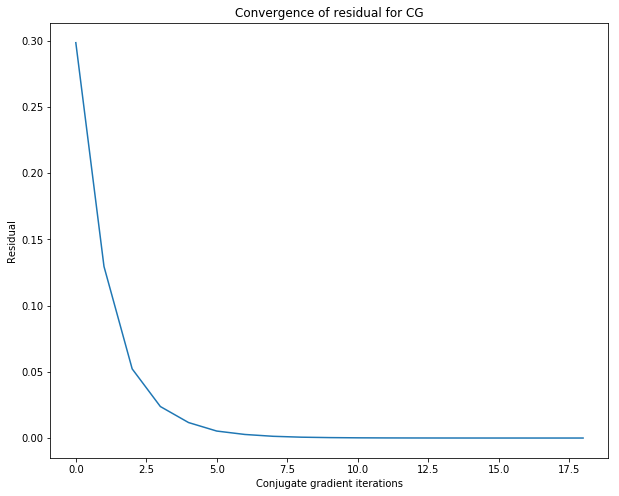

In [12]:
%%px

# data structure (grid 100x100)
discretization = Discretization(100, 100, 100, 0.01)
domain = Domain(rank, 4, discretization, comm)

if rank == 0:
    domain.x_new[1, 0] = 0.1
    domain.x_new[1, 1] = 0.2 

# diffusion function
S = np.zeros((domain.ny, domain.nx),  dtype=np.float64)
diffusion(domain.x_new, S, discretization, domain)

# cg solver
# iteration parameters
max_cg_iters     = 200
max_newton_iters = 50
tolerance     = 1.e-6
# deltax holding the solution from the conjugate gradient function
deltax = np.zeros((domain.ny, domain.nx), dtype=np.float64)
# conjugate gradient object containing the variables needed for the computation
cgvar = CGVariables(domain.ny, domain.nx)
# cg_solver function
cg_converged = cg_solver(deltax, S, max_cg_iters, tolerance, discretization, domain, cgvar)

We can make the following observations: 
* The square root of the residual converges towards the tolerance at each step.
* The square root of the residual is the same for all the processes due to our **dot function using the MPI `.Allreduce()` function**.